<a href="https://colab.research.google.com/github/mhassandrew/PHPStormSourceTreeTest/blob/master/agoldstein1_CSCI_390_AIFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Andrew Goldstein CSCI-390

The [Radiological Society of North America](http://www.rsna.org/) Pneumonia Detection Challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

This notebook covers the basics of parsing the competition dataset, training using a detector based on the [Mask-RCNN algorithm](https://arxiv.org/abs/1703.06870) for object detection and instance segmentation.  

This notebook is a student modified version of the notebook developed by [MD.ai](https://www.md.ai), the platform for medical AI. 
This notebook requires Google's [TensorFlow](https://www.tensorflow.org/) machine learning framework.

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 
!pip3 install -q kaggle

In [0]:
# import the required python dependencies
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

### Download the test and train datasets as well as the csv of  annotations from Kaggle

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="agoldstein1"
os.environ['KAGGLE_KEY']="f08307ef58867063c18b027fad26bafa"

In [5]:
# then download the competition dataset
!kaggle competitions download -c rsna-pneumonia-detection-challenge

# creates a string variable of the root directory path 
ROOT_DIR = os.getcwd()

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 37.4MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 48.5MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 41.1MB/s]
 99% 372M/377M [00:02<00:00, 127MB/s]
100% 377M/377M [00:03<00:00, 130MB/s]
100% 3.29G/3.29G [00:28<00:00, 149MB/s]
100% 3.29G/3.29G [00:28<00:00, 123MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 40.7kB/s]


###Unzip the test and train datasets as well as the csv of  annotations

In [0]:
# unzipping takes a few minutes
!unzip -q -o stage_2_test_images.zip -d stage_2_test_images
!unzip -q -o stage_2_train_images.zip -d stage_2_train_images
!unzip -q -o stage_2_train_labels.csv.zip

### Install Mask-RCNN model from Matterport's github

In [7]:
# gets Mask-RCNN model from github
os.chdir(ROOT_DIR)
!git clone https://github.com/matterport/Mask_RCNN.git

# intalls Mask-RCNN model
os.chdir('Mask_RCNN')
!python setup.py -q install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 914 (delta 0), reused 0 (delta 0), pack-reused 913
Receiving objects: 100% (914/914), 112.91 MiB | 27.81 MiB/s, done.
Resolving deltas: 100% (537/537), done.
zip_safe flag not set; analyzing archive contents...


In [8]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
# creates string variables of the image directory paths 
train_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_2_test_images')

### Functions and classes setup for Mask-RCNN

In [0]:
# functions gets dicom_fps which is a list of the dicom image path and filenames 
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

# function parses the dataset returns a list of the image filenames and the annotations dictionary
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    # image_annotions is a dictionary of the annotations keyed by the filenames
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [35]:
# The following parameters have been set to reduce running time and are not optimal 

# this class overrides values in the base Config class for training pneumonia detection on the RSNA pneumonia dataset.
class DetectorConfig(Config):
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8 
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    RPN_ANCHOR_SCALES = (32, 64)
    
    TRAIN_ROIS_PER_IMAGE = 16
    
    MAX_GT_INSTANCES = 3
    
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
    STEPS_PER_EPOCH = 100
    
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [0]:
# Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
class DetectorDataset(utils.Dataset):

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image
    
    #this function loads the mask
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

### Examine the annotation data, parse the dataset, and view dicom fields

In [13]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'stage_2_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
# read dicom image from filepath 
ds = pydicom.read_file(image_fps[0]) 

# get image array
image = ds.pixel_array

In [16]:
# show dicom fields 
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23894.1517874450.681005
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: 'df5fc041-24a9-44f3-8f22-d2bfca421bfc'
(0010, 0020) Patient ID                          LO: 'df5fc041-24a9-44f3-8f22-d2bfca421bfc'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

### Split the data into training and validation datasets

In [18]:
# The following parameters have been set to reduce running time and only used only a portion of the images
# To use all the images do: image_fps_list = list(image_fps)

image_fps_list = list(image_fps[:1000]) 

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

900 100


### Create and prepare the training dataset using the DetectorDataset class.

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Test Random Sample Annotation: 

bounding box with (x, y) of the the top left corner as well as the width and height.

In [20]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    cdd90da1-0fa8-4704-b75e-ab38320b14ed
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target                                          0
 Name: 22819, dtype: object]

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display Random Image with Bounding Boxes

(1024, 1024, 3)
/content/stage_2_train_images/e6dc5d04-2f76-425f-99d7-cae3aa095122.dcm
[1 1]


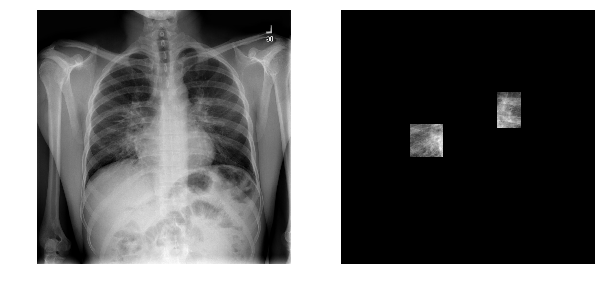

In [39]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [0]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

### Image Augmentation: 
allows finetuning some variables to custom values

In [0]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

### Training the model

In [25]:
# training a model can take up to few hours. 
# The following parameters have been set to reduce running time and have limited the training to one epoch
NUM_EPOCHS = 1

# Train Mask-RCNN Model
# dataset_train and dataset_val are derived from DetectorDataset 
# DetectorDataset loads images from image filenames and  masks from the annotation data
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='all',
            augmentation=augmentation)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/pneumonia20181214T1246/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b    

In [26]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/logs/pneumonia20181214T1246/mask_rcnn_pneumonia_0001.h5


In [27]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /content/logs/pneumonia20181214T1246/mask_rcnn_pneumonia_0001.h5
Re-starting from epoch 1


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

### Comparing the predicted box to the expected value



*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



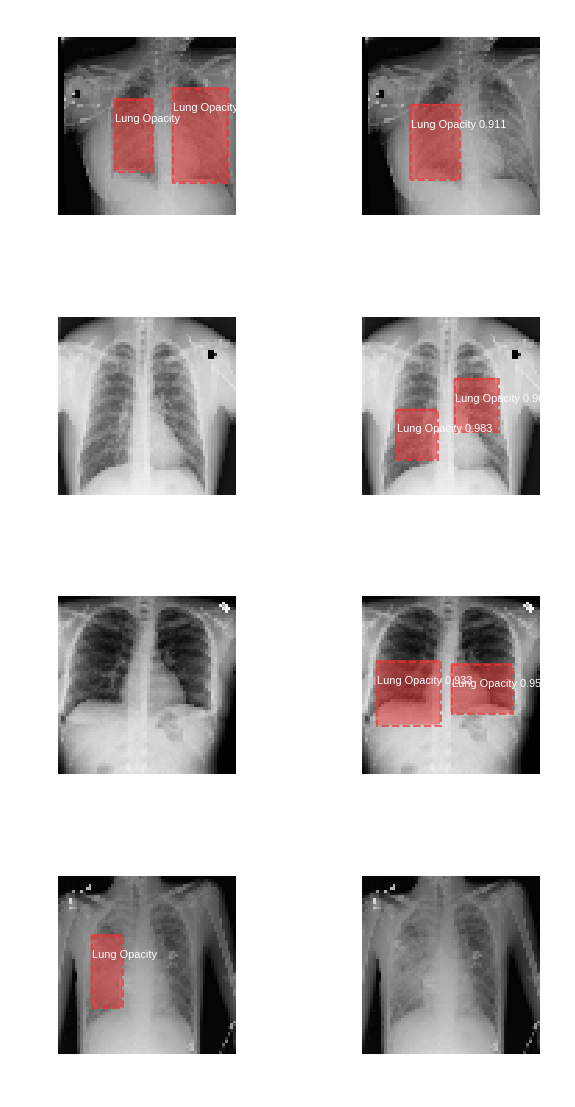

In [67]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

###Creating the submission file

In [0]:
# Make predictions on test images, write out sample submission 
def predict(image_fps, filepath='sample_submission.csv', min_conf=0.98): 
    
    # assume square image
    
    with open(filepath, 'w') as file:
      for image_id in tqdm(image_fps): 
        ds = pydicom.read_file(image_id)
        image = ds.pixel_array
          
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1) 
            
        patient_id = os.path.splitext(os.path.basename(image_id))[0]

        results = model.detect([image])
        r = results[0]

        out_str = ""
        out_str += patient_id 
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
        if len(r['rois']) == 0: 
            pass
        else: 
            num_instances = len(r['rois'])
            out_str += ","
            for i in range(num_instances): 
                if r['scores'][i] > min_conf: 
                    out_str += ' '
                    out_str += str(round(r['scores'][i], 2))
                    out_str += ' '

                    # x1, y1, width, height 
                    x1 = r['rois'][i][1]
                    y1 = r['rois'][i][0]
                    width = r['rois'][i][3] - x1 
                    height = r['rois'][i][2] - y1 
                    bboxes_str = "{} {} {} {}".format(x1, y1, \
                                                      width, height)    
                    out_str += bboxes_str

        file.write(out_str+"\n")

In [32]:
# predict only the first 50 entries
sample_submission_fp = 'sample_submission.csv'
predict(test_image_fps[:50], filepath=sample_submission_fp)

100%|██████████| 50/50 [00:07<00:00,  7.04it/s]


In [85]:
output = pd.read_csv(sample_submission_fp, names=['id', 'pred_string'])
output.head(50)

,id,pred_string
0,26e7295a-4039-463f-974f-e6402e5c9fa0,0.99 152 410 234 196
1,0092f442-ccb5-49a2-81cf-b6ca3f829a53,NaN
2,14ba4cea-0fd8-40a9-aa01-4e6c05da9fa5,NaN
3,302d8a19-5868-4286-be5d-a9be0b7310c1,NaN
4,10c6f9ca-4e9f-48f3-848d-4a5c2b8daf89,NaN
5,2376e0ed-344d-4492-897e-f2359f9881ae,0.99 129 405 312 298 0.98 552 376 325 322
6,1d942bbd-470f-4766-9813-80281a270f38,NaN
7,04384b80-0b9e-4744-85e4-f5184fc073e9,NaN
8,0e9709fd-a769-4d60-8a06-29a41c7c8297,NaN
9,2d281227-f786-4bfe-a4b7-f900a2f3d23e,NaN
